# Import library need

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import Dense, LSTM
from matplotlib.animation import FuncAnimation
import math
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
!pip install pmdarima
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.7 MB/s eta 0:00:00


In [ ]:
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
%matplotlib inline

# Read Data

In [ ]:
!wget -O "HNX.csv" https://raw.githubusercontent.com/Prosecutor22/StockPrediction/main/data/HNX.csv
!wget -O "HNX30.csv" https://raw.githubusercontent.com/Prosecutor22/StockPrediction/main/data/HNX30.csv
!wget -O "VNI.csv" https://raw.githubusercontent.com/Prosecutor22/StockPrediction/main/data/VNI.csv
!wget -O "VN100.csv" https://raw.githubusercontent.com/Prosecutor22/StockPrediction/main/data/VN100.csv
!wget -O "VN30.csv" https://raw.githubusercontent.com/Prosecutor22/StockPrediction/main/data/VN30.csv

--2023-04-10 15:57:31--  https://raw.githubusercontent.com/Prosecutor22/DM222/main/data/HNX.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 280301 (274K) [text/plain]
Saving to: ‘HNX.csv’

HNX.csv             100%[===================>] 273.73K  --.-KB/s    in 0.004s  

2023-04-10 15:57:31 (61.5 MB/s) - ‘HNX.csv’ saved [280301/280301]

--2023-04-10 15:57:31--  https://raw.githubusercontent.com/Prosecutor22/DM222/main/data/HNX30.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139020 (136K) [text/plain]
Saving to: ‘HNX30.csv’

In [ ]:
index_list = ["VNI", "VN30", "VN100","HNX", "HNX30"]

In [ ]:
for index in index_list:
  globals()[index] = pd.read_csv(f"{index}.csv", parse_dates=['Date'], index_col='Date').filter(['Price'])
  globals()[index] = globals()[index].iloc[::-1]

In [ ]:
VNI["Price"] = pd.to_numeric(VNI["Price"].apply(lambda x: x.replace(",", "")))
VN30["Price"] = pd.to_numeric(VN30["Price"].apply(lambda x: x.replace(",", "")))
VN100["Price"] = pd.to_numeric(VN100["Price"].apply(lambda x: x.replace(",", "")))


# Prediction 


## Preprocessing data



In [ ]:
data = VNI
data = data[data.index > "2018-01-01"]
training_data_len = int(0.8*len(data))
train, test = data[:training_data_len], data[training_data_len:]

In [ ]:
train

,Price
Date,
2018-01-02,995.77
2018-01-03,1005.67
2018-01-04,1019.75
2018-01-05,1012.65
2018-01-08,1022.90
...,...
2020-07-28,813.36
2020-07-29,790.84
2020-07-30,801.13


In [ ]:
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .8))
data

,Price
Date,
2018-01-02,995.77
2018-01-03,1005.67
2018-01-04,1019.75
2018-01-05,1012.65
2018-01-08,1022.90
...,...
2021-03-19,1194.05
2021-03-22,1194.43
2021-03-23,1183.45


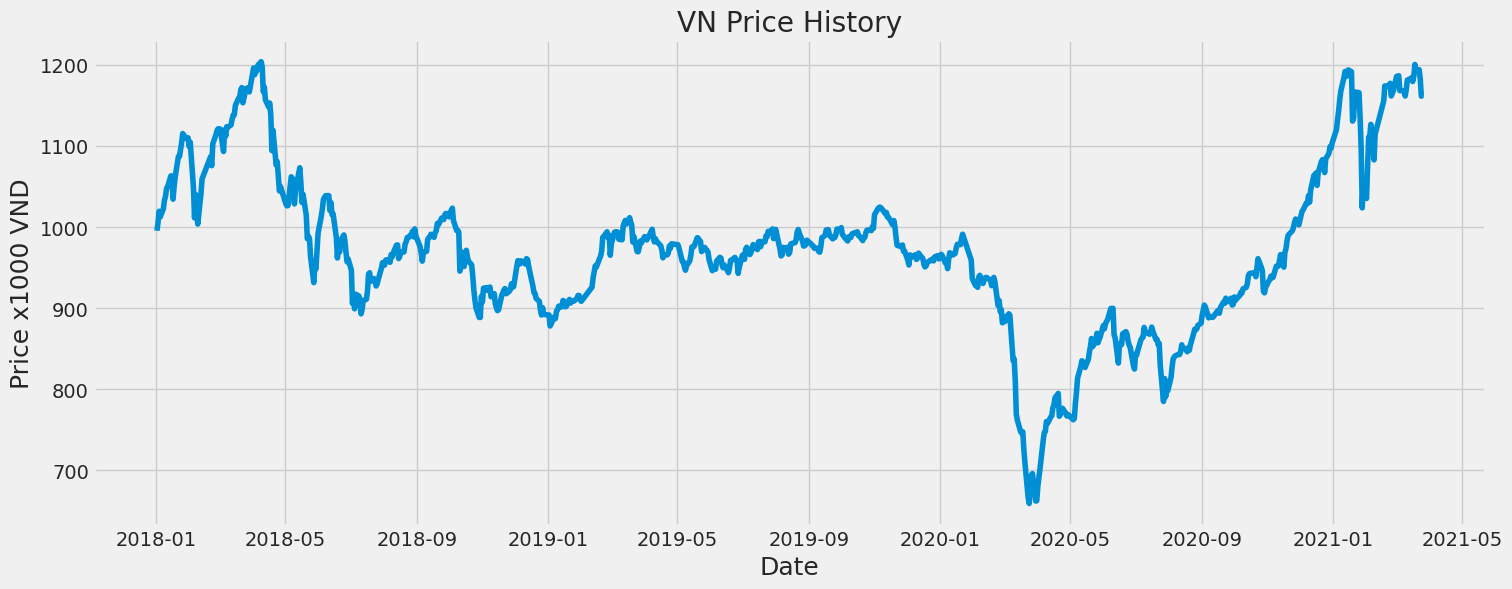

In [ ]:
plt.figure(figsize=(16,6))
plt.title('VN Price History')
plt.plot(data['Price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price x1000 VND', fontsize=18)
plt.show()

## LSTM model


### Scale data

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(dataset[:training_data_len])
scaled_data = scaler.transform(dataset)
scaled_data

array([[0.61740534],
       [0.63556648],
       [0.66139566],
       [0.648371  ],
       [0.6671742 ],
       [0.68672953],
       [0.69507631],
       [0.71353097],
       [0.71708982],
       [0.74159818],
       [0.74066261],
       [0.68880247],
       [0.71734664],
       [0.73902994],
       [0.78553346],
       [0.78553346],
       [0.81699442],
       [0.83730188],
       [0.82658864],
       [0.82798283],
       [0.82761594],
       [0.80800558],
       [0.81785662],
       [0.71452157],
       [0.64644482],
       [0.69955239],
       [0.66781626],
       [0.63239287],
       [0.70182712],
       [0.73473731],
       [0.78503816],
       [0.76463898],
       [0.81383915],
       [0.83526563],
       [0.84458468],
       [0.84812518],
       [0.83757705],
       [0.84751981],
       [0.79665028],
       [0.84583211],
       [0.83110141],
       [0.85291312],
       [0.85155562],
       [0.85683886],
       [0.86971676],
       [0.87848547],
       [0.87971456],
       [0.900

### Build model

In [ ]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(20, len(train_data)):
    x_train.append(train_data[i-20:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(624, 20, 1)

In [ ]:
INPUT_SHAPE = (20,1)
OUTPUT_SHAPE = (1,)

In [ ]:
enco_deco = Sequential()
# Encoder
enco_deco.add(LSTM(100, input_shape=INPUT_SHAPE, return_sequences=True))
# (20,100)
enco_deco.add(LSTM(units=50,return_sequences=True))
# 20x50
enco_deco.add(LSTM(units=25))
#25 

#feature vector
enco_deco.add(layers.RepeatVector(INPUT_SHAPE[0]))

#decoder
enco_deco.add(LSTM(units=100,return_sequences=True))
enco_deco.add(LSTM(units=50))
# enco_deco.add(layers.TimeDistributed(layers.Dense(units=1)))
enco_deco.add(layers.Dense(20))
enco_deco.add(layers.Dense(1))
enco_deco.compile(optimizer='adam', loss='mse')
enco_deco.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 20, 50)            30200     
                                                                 
 lstm_2 (LSTM)               (None, 25)                7600      
                                                                 
 repeat_vector (RepeatVector  (None, 20, 25)           0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 20, 100)           50400     
                                                                 
 lstm_4 (LSTM)               (None, 50)                30200     
                                                        

### Train model

In [ ]:
enco_deco.compile(optimizer='adam', loss='mean_squared_error')
start = time.time()
history= enco_deco.fit(x_train, y_train, batch_size=16, epochs=20, shuffle =True)
end = time.time()
print(end - start)

Epoch 1/20
39/39 [==============================] - 15s 17ms/step - loss: 0.0337
Epoch 2/20
39/39 [==============================] - 1s 16ms/step - loss: 0.0075
Epoch 3/20
39/39 [==============================] - 1s 17ms/step - loss: 0.0053
Epoch 4/20
39/39 [==============================] - 1s 16ms/step - loss: 0.0046
Epoch 5/20
39/39 [==============================] - 1s 17ms/step - loss: 0.0047
Epoch 6/20
39/39 [==============================] - 1s 16ms/step - loss: 0.0039
Epoch 7/20
39/39 [==============================] - 1s 17ms/step - loss: 0.0034
Epoch 8/20
39/39 [==============================] - 1s 23ms/step - loss: 0.0028
Epoch 9/20
39/39 [==============================] - 1s 21ms/step - loss: 0.0029
Epoch 10/20
39/39 [==============================] - 1s 22ms/step - loss: 0.0033
Epoch 11/20
39/39 [==============================] - 1s 25ms/step - loss: 0.0023
Epoch 12/20
39/39 [==============================] - 1s 17ms/step - loss: 0.0019
Epoch 13/20
39/39 [=================

In [ ]:
test_data = scaled_data[training_data_len - 20: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(20, len(test_data)):
    x_test.append(test_data[i-20:i, 0])    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
predictions = enco_deco.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = math.sqrt(mean_squared_error(y_test, predictions))

6/6 [==============================] - 2s 5ms/step


RMSE


<ipython-input-17-2b12a773f488>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


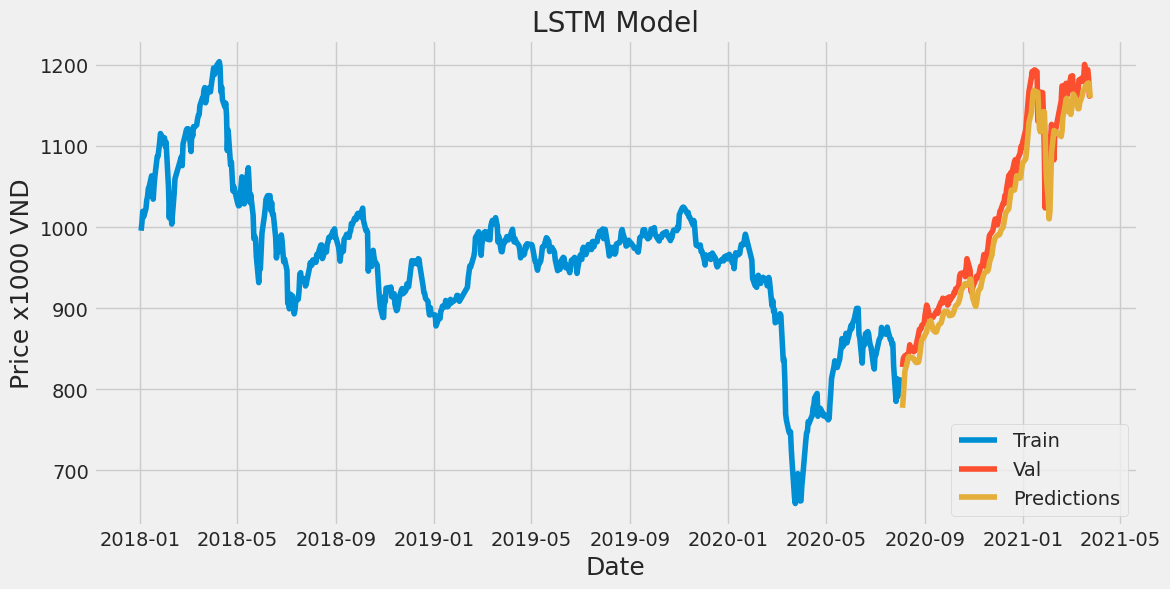

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
lstm_fig = plt.figure(figsize=(12,6))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price x1000 VND', fontsize=18)
plt.plot(train['Price'])
plt.plot(valid[['Price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
rmse

27.92831318813618

## ARIMA model

### Build model

In [ ]:
data = data[data.index > "2018-01-01"]
training_data_len = int(0.8*len(data))
train, test = data[:training_data_len], data[training_data_len:]

In [ ]:
result = adfuller(train)
print('p-value: %f' %result[1])

p-value: 0.413623


In [ ]:
train_diff = train.diff()[1:]
result = adfuller(train_diff)
print('p-value: %f' %result[1])

p-value: 0.000000


<Axes: xlabel='Date'>

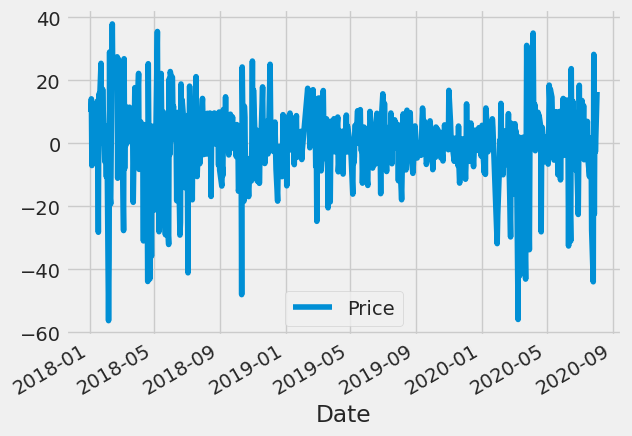

In [ ]:
train_diff.plot()

In [ ]:
print(ndiffs(train, test='adf'))
print(ndiffs(train, test='kpss'))
print(ndiffs(train, test='pp'))

1
1
1


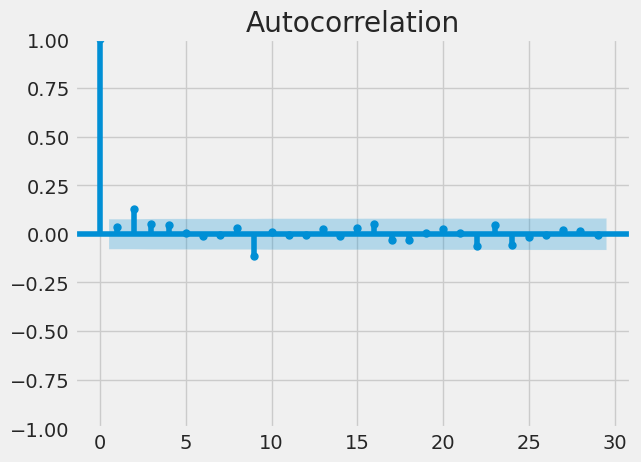

In [ ]:
plt = plot_acf(train.Price.diff().dropna())
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


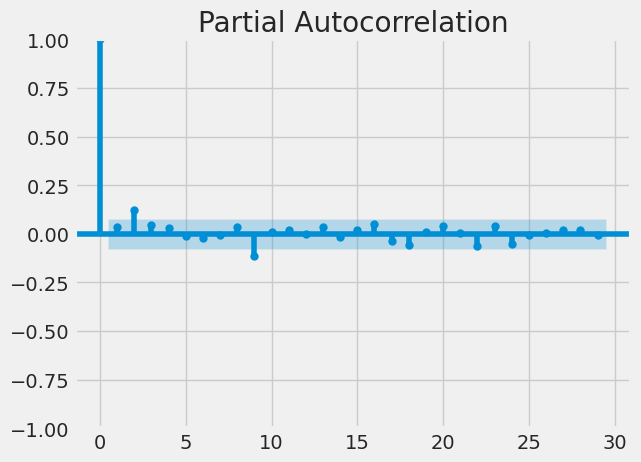

In [ ]:
plt = plot_pacf(train.Price.diff().dropna())
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train.Price, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  644
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2498.442
Date:                Mon, 10 Apr 2023   AIC                           5006.885
Time:                        15:34:18   BIC                           5029.216
Sample:                             0   HQIC                          5015.551
                                - 644                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5050      0.286      1.768      0.077      -0.055       1.065
ar.L2         -0.0088      0.243     -0.036      0.971      -0.484       0.467
ma.L1         -0.4805      0.284     -1.692      0.0

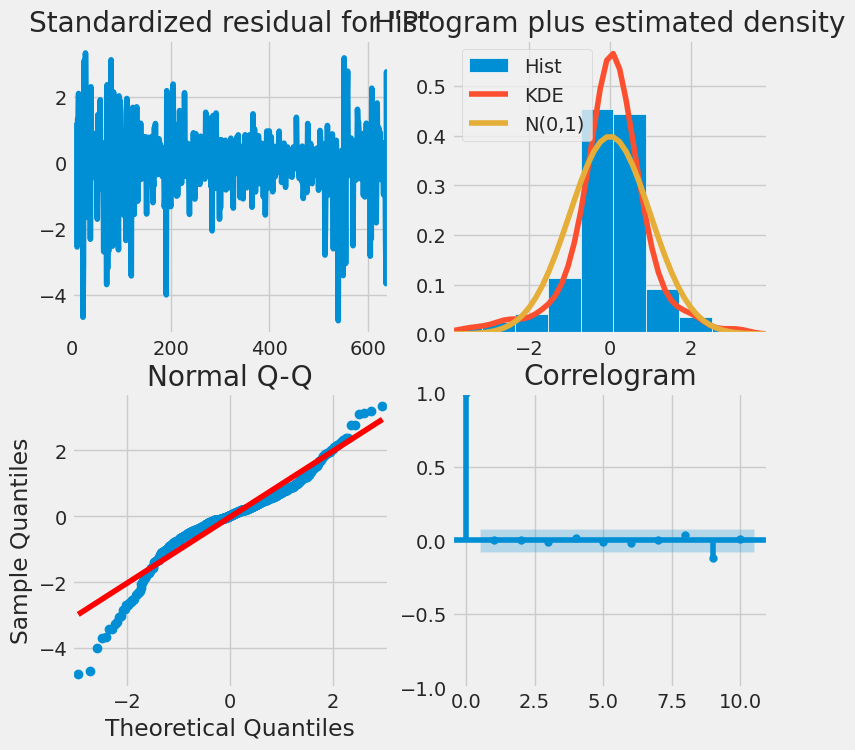

In [ ]:
model_fit.plot_diagnostics(figsize=(8,8))
plt.show()

### Train model without update price

In [ ]:
history = [x for x in train.Price]
model = ARIMA(history, order=(2,1,2))
fitted_model = model.fit()

In [ ]:
predictions = fitted_model.predict(start=1, end=len(test), typ='levels')

In [ ]:
rmse = math.sqrt(mean_squared_error(test, predictions))
print('rmse: %f' %rmse)

rmse: 186.287230


### Train model with update price

In [ ]:
history = [x for x in train.Price]
predictions = list()

In [ ]:
for t in range(len(test)):
  model = ARIMA(history, order=(2,1,2))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  history.append(test.Price[t])

In [ ]:
rmse = math.sqrt(mean_squared_error(test, predictions))
print('rmse: %f' %rmse)

rmse: 14.220762


In [ ]:
import matplotlib.pyplot as plt

<ipython-input-35-80909e13b9e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_valid['Predictions'] = predictions


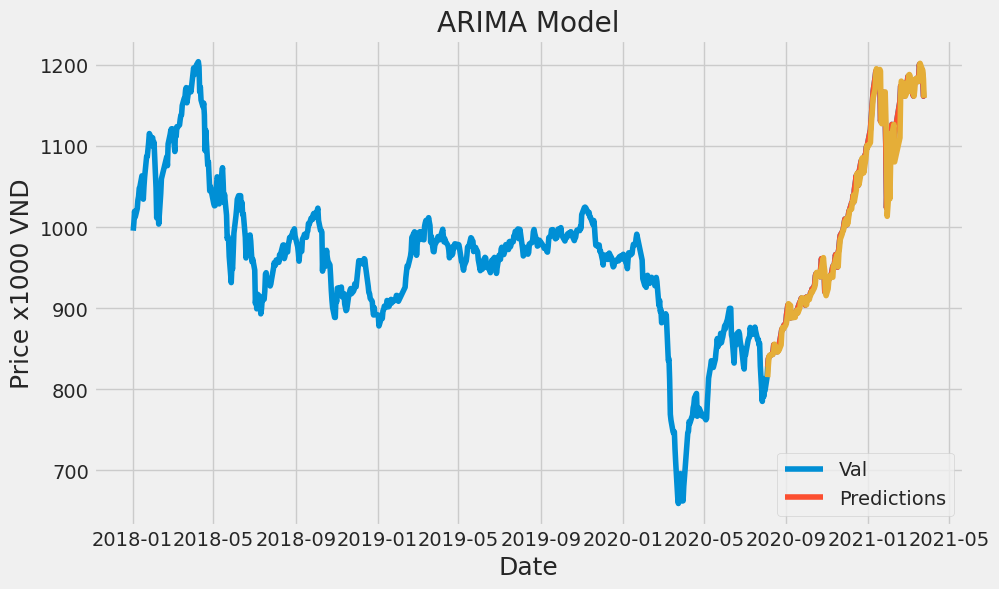

In [ ]:
data_valid = data[training_data_len:]
data_valid['Predictions'] = predictions
plt.figure(figsize=(10,6))
plt.title('ARIMA Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price x1000 VND', fontsize=18)
plt.plot(data['Price'])
plt.plot(data_valid[['Price', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

### Auto ARIMA model

In [ ]:
import pmdarima as pm
model = pm.auto_arima(train.Price, start_p=0, start_q=0,
                      test='adf',
                      max_p=5,max_q=5,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      supress_warning=True,
                      stepwise=True
                      )
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5013.007, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5014.218, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5014.374, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5011.367, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5010.149, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5006.748, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5006.252, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5007.003, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5008.729, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5004.495, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5012.550, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=5005.219, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5004.952, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5008.354, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]          

In [ ]:
history = [x for x in train.Price]
predictions = list()
for t in range(len(test)):
  model = ARIMA(history, order=(2,1,0))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  history.append(test.Price[t])
rmse = math.sqrt(mean_squared_error(test, predictions))
print('rmse: %f' %rmse)

rmse: 14.107963


<ipython-input-38-4739d53b821b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_valid['Predictions'] = predictions


<Figure size 1200x600 with 0 Axes>

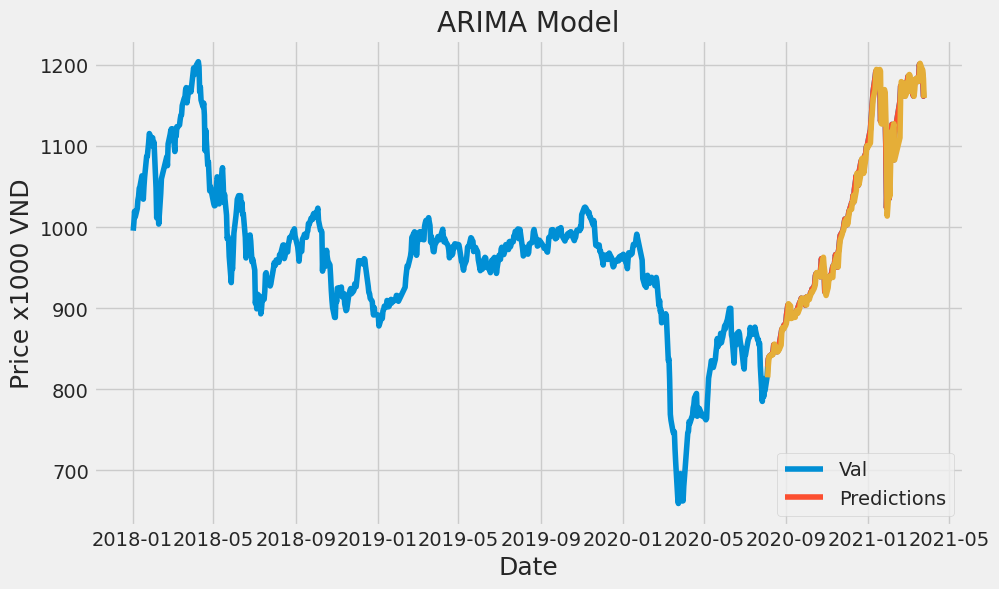

In [ ]:
data_valid = data[training_data_len:]
plt.figure(figsize=(12,6))
data_valid['Predictions'] = predictions
plt.figure(figsize=(10,6))
plt.title('ARIMA Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price x1000 VND', fontsize=18)
plt.plot(data['Price'])
plt.plot(data_valid[['Price', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
diff = list()
for i in range(len(test)):
  diff.append(abs(test.Price[i] - predictions[i]))

In [ ]:
ser = pd.Series(diff)
ser.describe()

count    161.000000
mean       8.890289
std       10.988510
min        0.022731
25%        2.385004
50%        5.656233
75%       10.976239
max       68.255230
dtype: float64